In this notebook is about to pre-processing, cleansing, scaling, and storing the data from Neo4J to CSV. The process consists of these steps:
- pre-process Neo4J database (type-casting for numerical and data types)
- load data from Neo4J to python objects using the offical Neo4J driver
- Cleansing:
    - Fill missing values
    - Convert genre embeddings from a list to proper pandas columns
- Scaling
- Storing data into CSV files
- Data profiling / insights


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Preprocess Neo4J data

In [2]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
    """ Wrapper function to transform cursor object to 
        human readable pd.DataFrame. """

    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())


def preprocess_neo4j_db(file_path:str) -> None:
    """Execute some type casts and data preprocessing steps on neo4j."""

    with open(file_path, mode='r', encoding='utf-8') as f:
        query = f.read()

    queries = [query for query in query.split(';')[:-1]] 

    with driver.session() as session:
        for query in queries:
            result = session.run(query)
            print(result)


preprocess_neo4j_db(file_path='./neo4j_cypher_queries/01_db_preprocessing.txt')

### Load data

In [3]:
# User
query = """
MATCH (u:User)
RETURN u.userId as userId
"""

user_df = fetch_data(query)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [4]:
movie_query = """
MATCH (m:Movie)
RETURN m.movieId AS movieId,
    m.imdbRating AS imdbRating,
    m.imdbVotes AS imdbVotes,
    m.runtime AS runtime,
    m.year AS year,
    m.genreEmbedding AS genreEmbedding,
    m.title AS title,
    m.plot AS plot,
    m.num_popular_actors AS num_popular_actors,
    m.num_popular_directors AS num_popular_directors
"""

movie_df = fetch_data(movie_query)

print(movie_df.shape)
movie_df.info()

(9125, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   imdbRating             9058 non-null   float64
 2   imdbVotes              9055 non-null   float64
 3   runtime                9062 non-null   float64
 4   year                   9096 non-null   float64
 5   genreEmbedding         9125 non-null   object 
 6   title                  9125 non-null   object 
 7   plot                   9083 non-null   object 
 8   num_popular_actors     9125 non-null   int64  
 9   num_popular_directors  9125 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 713.0+ KB


In [5]:
rating_query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId,
    m.movieId AS movieId,
    r.rating AS rating
"""

rating_df = fetch_data(rating_query)

print(rating_df.shape)
rating_df.info()

(100004, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


### Clean data

The genreEmbeddings must be converted from a list into proper columns.

In [6]:
query = """
MATCH(g:Genre)
WITH g ORDER BY g.name
RETURN g.name AS header
"""

header_df = fetch_data(query)
genre_headers = header_df['header'].to_list()


genre_embed = np.array(movie_df['genreEmbedding'].values.tolist())
genre_embed.shape

(9125, 20)

In [7]:
genre_df = pd.DataFrame(genre_embed, columns=genre_headers)

movie_df = pd.concat([movie_df, genre_df], axis=1)
movie_df.shape

(9125, 30)

In [8]:
# remove unnecessary columns
movie_df.drop(columns=['genreEmbedding', '(no genres listed)'], axis=1, inplace=True)

print(movie_df.shape)
movie_df.info()

(9125, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   imdbRating             9058 non-null   float64
 2   imdbVotes              9055 non-null   float64
 3   runtime                9062 non-null   float64
 4   year                   9096 non-null   float64
 5   title                  9125 non-null   object 
 6   plot                   9083 non-null   object 
 7   num_popular_actors     9125 non-null   int64  
 8   num_popular_directors  9125 non-null   int64  
 9   Action                 9125 non-null   int32  
 10  Adventure              9125 non-null   int32  
 11  Animation              9125 non-null   int32  
 12  Children               9125 non-null   int32  
 13  Comedy                 9125 non-null   int32  
 14  Crime                  9125 non-null   int32 

As we can see from the `.info()` for some attributes we have some null values:
- imdbRating: 67 (0.73%)
- imdbVotes: 70 (0.77%)
- runtime: 63 (0.69%)
- year: 29 (0.32%)
- plot: 42 (0.46%)

The rate of missing values is relatively low. Therefore, I decided to fill the missing values with the attributes mean value. 
For missing plots I just copied the title.

In [9]:
# numerical values
movie_df['imdbRating'].fillna(movie_df['imdbRating'].mean(), inplace=True)
movie_df['imdbVotes'].fillna(movie_df['imdbVotes'].mean(), inplace=True)
movie_df['runtime'].fillna(movie_df['runtime'].mean(), inplace=True)
movie_df['year'].fillna(movie_df['year'].mean(), inplace=True)

# plots
movie_df['plot'] = np.where(movie_df['plot'].isnull(), movie_df['title'], movie_df['plot'])
movie_df.loc[508:512, 'plot']

508    A group of women of Indian descent take a trip...
509    A young boy is bequeathed the ownership of a p...
510                                    Wedding Gift, The
511    Marco Sperelli is a teacher, he is divorced an...
512    Raymond Aibelli is a promising medical student...
Name: plot, dtype: object

In [10]:
assert not movie_df.isnull().values.any(), 'Null values in dataset!'

### Data scaling

In [11]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [12]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [13]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year', 'num_popular_actors', 'num_popular_directors']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [14]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,title,plot,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year,num_popular_actors,num_popular_directors
0,0,Toy Story,A cowboy doll is profoundly threatened and jea...,0,1,1,1,1,0,0,...,0,0,0,0,1.528928,5.144229,-0.876122,0.158905,2.943417,4.502288
1,1,Jumanji,When two kids find and play a magical board ga...,0,1,0,1,0,0,0,...,0,0,0,0,0.174897,1.394602,-0.058951,0.158905,1.228413,-0.218854
2,2,Grumpier Old Men,John and Max resolve to save their beloved bai...,0,0,0,0,1,0,0,...,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905,-0.486591,-0.218854
3,3,Waiting to Exhale,"Based on Terry McMillan's novel, this film fol...",0,0,0,0,1,0,0,...,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905,-0.486591,-0.218854
4,4,Father of the Bride Part II,"In this sequel, George Banks deals not only wi...",0,0,0,0,1,0,0,...,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905,1.228413,-0.218854


In [15]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   title                  9125 non-null   object 
 2   plot                   9125 non-null   object 
 3   Action                 9125 non-null   int32  
 4   Adventure              9125 non-null   int32  
 5   Animation              9125 non-null   int32  
 6   Children               9125 non-null   int32  
 7   Comedy                 9125 non-null   int32  
 8   Crime                  9125 non-null   int32  
 9   Documentary            9125 non-null   int32  
 10  Drama                  9125 non-null   int32  
 11  Fantasy                9125 non-null   int32  
 12  Film-Noir              9125 non-null   int32  
 13  Horror                 9125 non-null   int32  
 14  IMAX                   9125 non-null   int32  
 15  Musi

In [16]:
movie_df.describe()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year,num_popular_actors,num_popular_directors
count,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,...,9125.000000,9125.000000,9125.000000,9125.000000,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03
mean,4562.000000,0.169315,0.122411,0.048986,0.063890,0.363288,0.120548,0.054247,0.478356,0.071671,...,0.086795,0.189479,0.040219,0.018411,7.697222e-16,3.114708e-18,-1.993413e-16,-5.095662e-15,1.245883e-17,2.024560e-17
std,2634.304937,0.375051,0.327778,0.215851,0.244571,0.480973,0.325619,0.226516,0.499559,0.257957,...,0.281549,0.391910,0.196484,0.134439,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.951079e+00,-4.954719e-01,-3.682925e+00,-4.650468e+00,-4.865914e-01,-2.188541e-01
25%,2281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-5.988353e-01,-4.503885e-01,-4.497720e-01,-3.582321e-01,-4.865914e-01,-2.188541e-01
50%,4562.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.818045e-02,-3.532937e-01,-1.300096e-01,2.623321e-01,-4.865914e-01,-2.188541e-01
75%,6843.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.551962e-01,0.000000e+00,3.318695e-01,7.277552e-01,-4.865914e-01,-2.188541e-01
max,9124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.786243e+00,1.500774e+01,2.857755e+01,1.244892e+00,6.373426e+00,1.394457e+01


In [17]:
do_safe = False

if do_safe:
    # dataframes
    user_df.to_csv('./data/movieLens100k_users.csv', index=False)
    movie_df.to_csv('./data/movieLens100k_movies.csv', index=False)
    rating_df.to_csv('./data/movieLens100k_ratings.csv', index=False)

    # scaler and encoder objects
    with open('./data/encoder_user.pkl', 'wb') as f:
        pickle.dump(user_encoder, f)

    with open('./data/encoder_movie.pkl', 'wb') as f:
        pickle.dump(movie_encoder, f)

    with open('./data/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print('Data stored into CSV files.')

### Data Profiling

C:\Users\roman\AppData\Local\Temp\ipykernel_57452\1367372847.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  movie_df[movie_features].hist(bins=30, ax=ax)


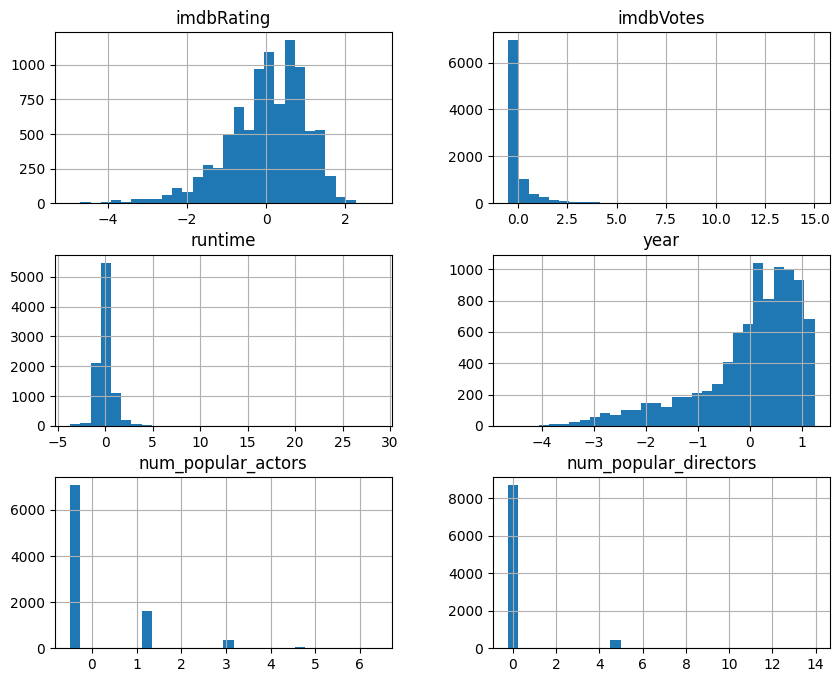

In [18]:
_, ax = plt.subplots(figsize=(10,8))

movie_features = ['imdbRating', 'imdbVotes', 'runtime', 'year', 
    'num_popular_actors', 'num_popular_directors']

movie_df[movie_features].hist(bins=30, ax=ax)

plt.show()

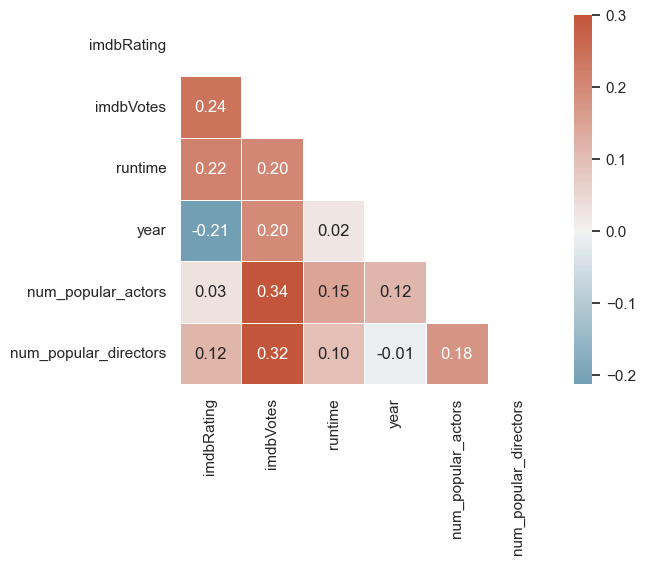

In [19]:
sns.set_theme(style="white")
corr = movie_df[movie_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f", vmax=.3, center=0,
            square=True, linewidths=.5)

plt.show()

### Visualize genre embeddings

In [20]:
genre_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
X = genre_df.drop(columns='(no genres listed)').values
X.shape

(9125, 19)

In [22]:
tsne = TSNE(n_components=2, perplexity=19, init='random', learning_rate='auto')
embed_reduced = tsne.fit_transform(X)

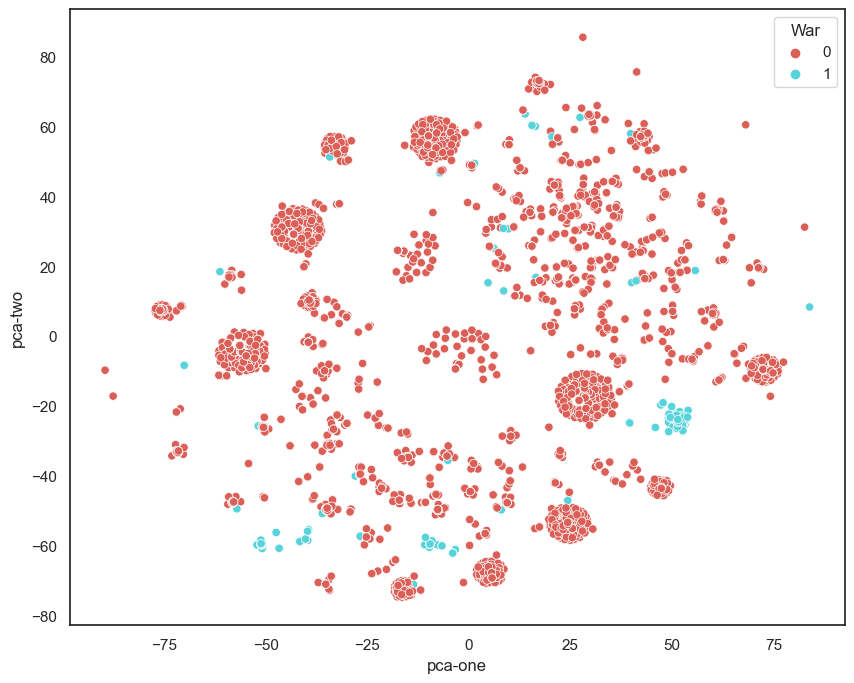

In [23]:
genre_df['pca-one'] = embed_reduced[:,0]
genre_df['pca-two'] = embed_reduced[:,1]

plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="War",
    palette=sns.color_palette("hls", 2),
    data=genre_df,
    legend="full"
)
plt.show()